In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import seaborn as sns
#import pyfolio
import datetime
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

In [2]:
def load_symbol(filename):
# Load symbol and get quotes, datetimes and volumes
    df_cur = pd.read_csv(filename)
    cur_col1 = df_cur.iloc[:, 4].values
    cur_index = df_cur.iloc[:, 0].values
    cur_volume = df_cur.iloc[:, 5].values
    
    return cur_col1, cur_index, cur_volume


def importSupportResistance(values_, quantile_, n_samples_):
# ml_strats/ordercompute mod
    # Removes values that are too close. Requires sorted list
    def cleanLevelFloats(ml_results_):
        for j in range(100):
            last_results = ml_results_
            for i in range(1, len(ml_results_)-1):
                # 0.001 is for symbols with a normal range within <0,10>. Multiply for f.ex. USDJPY
                if ml_results_[i] - ml_results_[i-1] < 0.001 or ml_results_[i+1] - ml_results_[i-1] < 0.001:
                    ml_results_[i] = 0
            ml_results_ = list(filter(lambda a: a != 0, ml_results_))
            if last_results == ml_results_:
                break
        return ml_results_

    bw_data = values_#.reshape(1, -1)

    # Calculate bandwidth and fit data
    # Greater quantile greater sample size. estimate_bandwidth for faster MeanShift processing
    bandwidth = estimate_bandwidth(bw_data, quantile=float(quantile_), n_samples=int(n_samples_))

    # Bin seeding for increased execution speed but fewer seeds, n_jobs=-2 for all but one active cpu core
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-2)
    ms.fit(values_)

    # Append maximas of all clusters to S/R array
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
        members = ms.labels_ == k
        values = bw_data[members, 0]
        ml_results.append(min(values))
        ml_results.append(max(values))

    # Remove duplicates and clean floats
    rnd_ml_results = [round(elem, 4) for elem in ml_results]
    #rnd_ml_results = list(set(rnd_ml_results))

    return cleanLevelFloats(sorted(rnd_ml_results))

In [54]:
def drop_zeros(index, rates, volume):
# Drops weekend values
    jj = 0
    for j in range(len(volume)):
        if volume[j] > 0:
            rates[jj] = rates[j]
            index[jj] = index[j]
            volume[jj] = volume[j]
            jj += 1

    rates = rates[:jj]
    index = index[:jj]
    volume = volume[:jj]

    return rates, index, volume

In [4]:
rates, index, volume = load_symbol('data/EURUSD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
index, rates, volume = drop_zeros(index, rates, volume)
'''
volume = volume
rates_ = rates.reshape(-1, 1)
quantile_ = 0.2
n_samples_ = 288
sr_levels = importSupportResistance(rates_[288:576], quantile_, n_samples_)
'''

'\nvolume = volume\nrates_ = rates.reshape(-1, 1)\nquantile_ = 0.2\nn_samples_ = 288\nsr_levels = importSupportResistance(rates_[288:576], quantile_, n_samples_)\n'

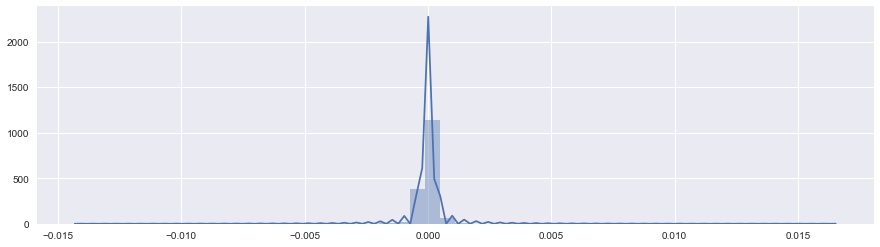

std: 0.000333515211894
stdmax: 49.43 deviations
skewness: -0.00090
kurtosis: 94.00733837721761


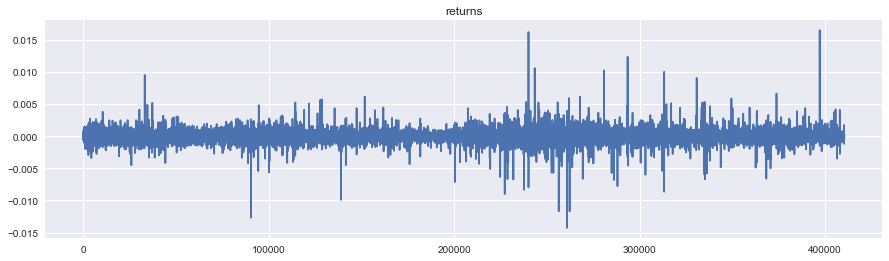

In [385]:
rate_return = [(rates[i] - rates[i-1])/rates[i-1] for i in range(1, len(rates))]
#plt.plot(rate_return[:100000])
plt.figure(figsize=(15, 4))
sns.distplot(rate_return)
plt.show()
plt.figure(figsize=(15, 4))
plt.title('returns')
plt.plot(rate_return)
print('std:', np.std(rate_return))
print('stdmax: %.2f deviations' % (max(rate_return)/np.std(rate_return)))
print('skewness: %.5f' % ((np.mean(rate_return) - np.median(rate_return))/np.std(rate_return)))
from scipy.stats import kurtosis
print('kurtosis:', kurtosis(rate_return))

01.11.2006 20:00:00.000
1.27531


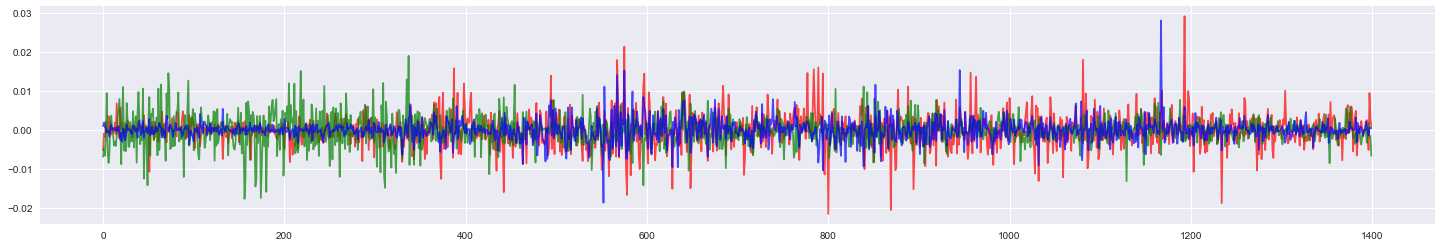

In [434]:
rates_1, index_1, volume_1 = load_symbol('data/EURUSD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv') #2012-2017_EU_H1.csv') 
rates_1, index_1, volume_1 = drop_zeros(index_1, rates_1, volume_1)
rates_2, index_2, volume_2 = load_symbol('data/EURAUD_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv') #2012-2017_EA_H1.csv') #EURAUD_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
rates_2, index_2, volume_2 = drop_zeros(index_2, rates_2, volume_2)
rates_3, index_3, volume_3 = load_symbol('data/EURCHF_Candlestick_4_h_BID_02.01.2006-08.07.2017.csv') #2012-2017_ECH_H1.csv') #EURCHF_Candlestick_15_m_BID_01.01.2015-24.06.2017.csv')
rates_3, index_3, volume_3 = drop_zeros(index_3, rates_3, volume_3)

rate_return_1 = [(rates_1[i] - rates_1[i-1])/rates_1[i-1] for i in range(1, len(rates_1))]
rate_return_2 = [(rates_2[i] - rates_2[i-1])/rates_2[i-1] for i in range(1, len(rates_2))]
rate_return_3 = [(rates_3[i] - rates_3[i-1])/rates_3[i-1] for i in range(1, len(rates_3))]
rate_return_1.insert(0,0)
rate_return_2.insert(0,0)
rate_return_3.insert(0,0)

fig = plt.figure(figsize=(25, 4))
a = fig.add_subplot(111)
a.plot(rate_return_1[4000:5400], 'r', alpha=0.7) # EURUSD
a.plot(rate_return_2[4000:5400], 'g', alpha=0.7) # EURAUD
a.plot(rate_return_3[4000:5400], 'b', alpha=0.7) # EURCHF

print(index_1[1350])
print(rates_1[1350])

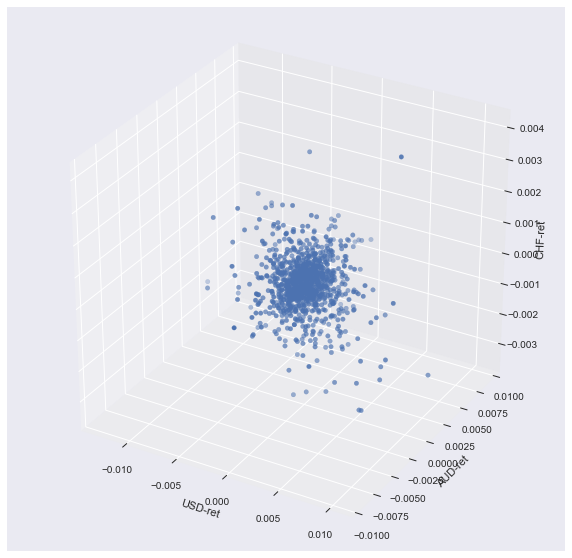

In [446]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rate_return_1[:1000], rate_return_2[:1000], zs=rate_return_3[:1000], zdir='z', s=20, c=None, depthshade=True)
#ax.contourf(rate_return_1[:1000], rate_return_2[:1000], Z=rate_return_3[:1000], zdir='z')
ax.set_xlabel('USD-ret')
ax.set_ylabel('AUD-ret')
ax.set_zlabel('CHF-ret')
plt.show()

In [171]:
print(len(rate_return_1))
print(len(rate_return_2)) 
print(len(rate_return_3))

61849
61840
61849


C:\Users\Eier\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


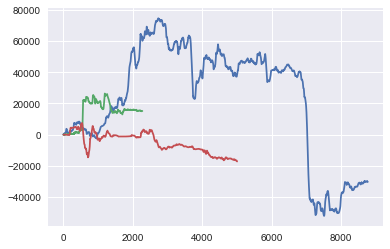

In [404]:
def run_shittest(rates_1_, rate_return_1_, rate_return_2_, rate_return_3_):    
    signals = [0]
    types = [0]
    
    min_len = min(len(rate_return_1), len(rate_return_2), len(rate_return_3))
    for i in range(1, min_len):
        
        ret_1_a = rate_return_1_[i] - rate_return_1_[i-1]
        ret_2_a = rate_return_2_[i] - rate_return_2_[i-1]
        ret_3_a = rate_return_3_[i] - rate_return_3_[i-1]
        
        if abs(ret_2_a - ret_3_a) <= 0.0005:
            if abs(ret_2_a)/ret_2_a - abs(ret_1_a)/ret_1_a == 0:
                if rate_return_1_[i] < 0:
                    signals.append(i)
                    types.append(1)
                elif rate_return_1_[i] > 0:
                    signals.append(i)
                    types.append(0)

    cumulative = [0]
    target = 0.001
    stop = 0.00001
    for i in range(1, len(signals)-1):
        if types[i-1] == 1:
            for j in range(signals[i]+1, signals[i+1]):
                if max(rates_1[signals[i]:j]) > rates_1_[signals[i]] + target:
                    cumulative.append(cumulative[-1] + (rates_1_[signals[i]] - rates_1_[j])*10000)
                    break
                elif min(rates_1[i:j]) < rates_1_[signals[i]] - stop:
                    cumulative.append(cumulative[-1] + (rates_1_[signals[i]] - rates_1_[j])*10000)
                    break
                else:
                    cumulative.append(cumulative[-1] + (rates_1_[signals[i]] - rates_1_[j])*10000)
        else:
            for j in range(signals[i]+1, signals[i+1]):
                if max(rates_1[signals[i]:j]) < rates_1_[signals[i]] - target:
                    cumulative.append(cumulative[-1] + (rates_1_[j] - rates_1_[signals[i]])*10000)
                    break
                elif min(rates_1[i:j]) > rates_1_[signals[i]] + stop:
                    cumulative.append(cumulative[-1] + (rates_1_[j] - rates_1_[signals[i]])*10000)
                    break
                else:
                    cumulative.append(cumulative[-1] + (rates_1_[j] - rates_1_[signals[i]])*10000)

    #cumulative_net = [cumulative[i] - 2*i for i in range(len(cumulative))]
    cumulative_net = cumulative
    return cumulative_net, signals, types


cumulative_net_1 = run_shittest(rates_1, rate_return_1, rate_return_2, rate_return_3)
cumulative_net_2 = run_shittest(rates_2, rate_return_2, rate_return_1, rate_return_3)
cumulative_net_3 = run_shittest(rates_3, rate_return_3, rate_return_2, rate_return_1)

#plt.figure(figsize=(15, 4))
#all_net = [cumulative_net_1[0][i] + cumulative_net_2[0][i] + cumulative_net_3[0][i] for i in range(len(cumulative_net_3[0]))]
#plt.plot(all_net)
plt.plot(cumulative_net_1[0])
plt.plot(cumulative_net_2[0])
plt.plot(cumulative_net_3[0])

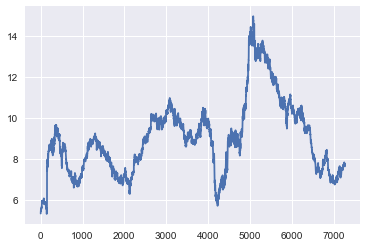

In [350]:
plt.plot(sharpe_6m(all_net, 2)[0])

16.12.2010 12:00:00.000


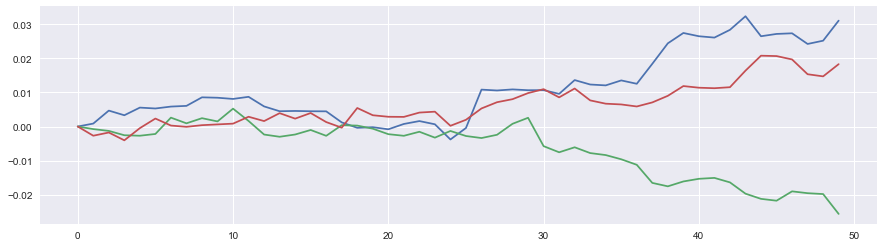

In [368]:
walk_1 = [sum(rate_return_1[7300:i]) for i in range(7300, 7350)]
walk_2 = [sum(rate_return_2[7300:i]) for i in range(7300, 7350)]
walk_3 = [sum(rate_return_3[7300:i]) for i in range(7300, 7350)]

plt.figure(figsize=(15, 4))
plt.plot(walk_1)
plt.plot(walk_2)
plt.plot(walk_3)

print(index_2[7323])
#print(index_1[3300])

In [405]:
def record_open_data(type_, open_rate, entryvals, typevals, x, rates): # 0 or 1
    tradetype = type_
    trade = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
    open_rate = rates[x]

    # Trades = open
    entryvals.append(x) #entryvals[ev] = x # Store position in delta array
    typevals.append(type_) # For line coloring in backtest visualization

    return trade, tradetype, open_rate, entryvals, typevals

def record_close_data(typeval, exitvals, gross_pips, x, rates, open_rate):
    if typeval == 1: 
        gross_pips.append(gross_pips[-1] + math.ceil((rates[x] - open_rate)*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((open_rates[0] - cur1_col1[samplesize+x])*10000))
    else:
        gross_pips.append(gross_pips[-1] + math.ceil((open_rate - rates[x])*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((cur1_col1[samplesize+x] - open_rates[0])*10000))
        
    trade = 0
    exitvals.append(x)
    
    return gross_pips, trade, exitvals

# ---
def volume_max(shift):
    pass

final pip val: 6432


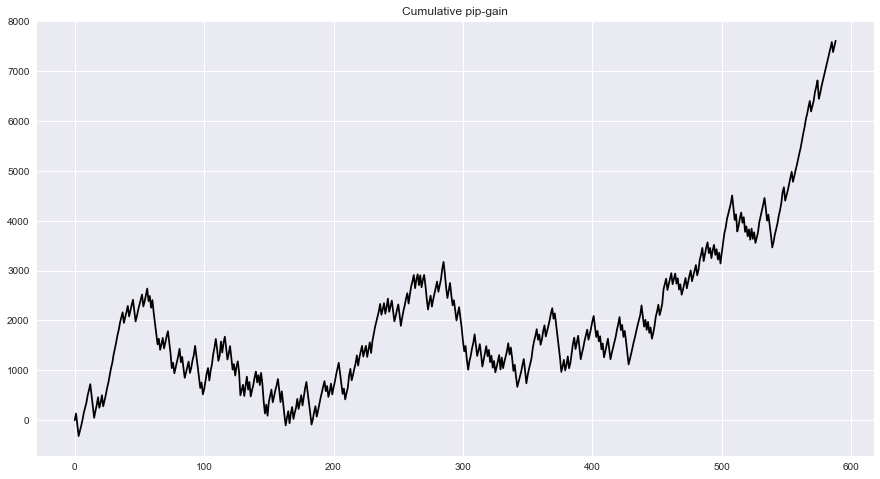

In [429]:
trade = 0
tradetype = 1
typevals = []
entryvals = []
exitvals = []
gross_pips = [0]
open_rate = 0
first_x = 0

target = 0.01
stop = 0.02
optimize = 0

min_len = min(len(rate_return_1), len(rate_return_2), len(rate_return_3))

for x in range(1, min_len):
    
    ret_1_a = rate_return_1[x] - rate_return_1[x-1]
    ret_2_a = rate_return_2[x] - rate_return_2[x-1]
    ret_3_a = rate_return_3[x] - rate_return_3[x-1]

    # if all closed
    if trade == 0:
        
        #print(abs(ret_2_a - ret_3_a))
        
        if abs(ret_2_a - ret_3_a) <= 0.005:
            if abs(ret_2_a)/ret_2_a - abs(ret_1_a)/ret_1_a == 0: # sgnx
                # Buy (tradetype 1)
                if rate_return_1[x] < 0:
                    trade, tradetype, open_rate, entryvals, typevals = record_open_data(1, open_rate,
                                                                                        entryvals, typevals, 
                                                                                        x, rates_1)
                # Sell (tradetype 0)
                elif rate_return_1[x] > 0:
                    trade, tradetype, open_rate, entryvals, typevals = record_open_data(0, open_rate,
                                                                                        entryvals, typevals, 
                                                                                        x, rates_1)
                    
    # if > 0 open
    else: 
        # Buy order
        if tradetype: # == 1:
            if rates_1[x] >= open_rate + target or rates_1[x] <= open_rate - stop:
                
                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                                gross_pips, x, rates_1, open_rate)

        # Sell order
        else:
            if rates_1[x] <= open_rate - target or rates_1[x] >= open_rate + stop:

                # Close trade and store data
                gross_pips, trade, exitvals = record_close_data(tradetype, exitvals, 
                                                                gross_pips, x, rates_1, open_rate)

                
net_pips = [gross_pips[i] - 2*i for i in range(len(gross_pips))]
#plt.plot(gross_pips)


if optimize:
    # Getting R^2 value
    model = LinearRegression()
    X = np.array([i for i in range(len(net_pips))]).reshape(-1, 1)
    y = net_pips
    model.fit(X, y)
    r_squared = model.score(X, y)        
    print('R^2: %.3f, pips: %.1f' % (r_squared, net_pips[-1]))

    fig = plt.figure(figsize=(10, 5))
    ccc = fig.add_subplot(111)
    plt.plot(net_pips)
    TITLENAME = 'R^2: %.4f, pips: %.1f, target: %.4f, stop: %.4f\n' % (r_squared, net_pips[-1], target, stop)

    # If score is negative e.g. loss, picture is rated by possible net if the strategy is reversed
    # Positive backtests are penalized for having low R^2-values: S*(1-R_S^2)^-1
    if net_pips[-1] <= 0:
        IMGNAME = 'data/bt_imgs/EURUSD_5m_volume/min/net_%.2f_%.1f_%.3f.png' % ((-(net_pips[-1] + 2*len(net_pips)) - 2*len(net_pips)), net_pips[-1], r_squared)
    else:
        IMGNAME = 'data/bt_imgs/EURUSD_5m_volume/max/net_%.2f_%.1f_%.3f.png' % (net_pips[-1]/(1-r_squared), net_pips[-1], r_squared)
    plt.title(TITLENAME)
    plt.savefig(IMGNAME)
    plt.close(fig)

else:     
    plt.figure(figsize=(15, 8))
    #plt.plot(net_pips, linewidth=2.0, color='r')
    print('final pip val:', net_pips[-1])
    plt.plot(gross_pips, 'k')
    plt.title('Cumulative pip-gain')
    #red_patch = mpatches.Patch(color='r', label='net gain')
    #black_patch = mpatches.Patch(color='k', label='gross gain')
    #plt.legend(handles=[red_patch, black_patch])


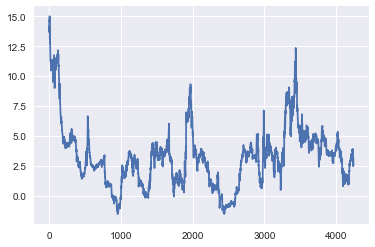

In [426]:
plt.plot(sharpe_6m(gross_pips, 10)[0])

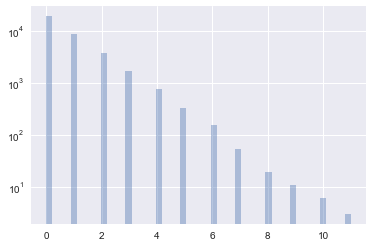

In [102]:
def get_consecutive(rate_return):
    count = 0
    max_count = [0]
    for i in range(1, len(rate_return)):
        if rate_return[i-1] < 0 and rate_return[i] < 0:
            count += 1
        elif rate_return[i-1] > 0 and rate_return[i] > 0:
            count += 1
        else:
            max_count.append(count)
            count = 0
    return max_count

sns.distplot(get_consecutive(rate_return_3), kde=False).set_yscale('log')

In [ ]:
days_ = [0]*288
n5 = 0
for i in range(1152, 4030):
    if index[i].split(' ')[1] == '00:00:00.000':
        n5 = 0
    days[n5] += volume[i]
    n5 += 1
    
days = [days[i]/10 for i in range(288)]

plt.plot(days)

In [ ]:
volume_delta = [volume[i] - volume[288+i] for i in range(28800)]
plt.plot(volume_delta)
plt.show()

In [11]:
def record_open_data(type_, open_rate, entryvals, typevals, x, rates): # 0 or 1
    tradetype = type_
    trade = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
    open_rate = rates[x]

    # Trades = open
    entryvals.append(x) #entryvals[ev] = x # Store position in delta array
    typevals.append(type_) # For line coloring in backtest visualization

    return trade, tradetype, open_rate, entryvals, typevals

def record_close_data(typeval, exitvals, gross_pips, x, rates, open_rate):
    if typeval == 1: 
        gross_pips.append(gross_pips[-1] + math.ceil((rates[x] - open_rate)*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((open_rates[0] - cur1_col1[samplesize+x])*10000))
    else:
        gross_pips.append(gross_pips[-1] + math.ceil((open_rate - rates[x])*10000))
        #net_pips_1.append(net_pips_1[-1] + math.ceil((cur1_col1[samplesize+x] - open_rates[0])*10000))
        
    trade = 0
    exitvals.append(x)
    
    return gross_pips, trade, exitvals

# ---
def volume_max(shift):
    pass

1.17644277091


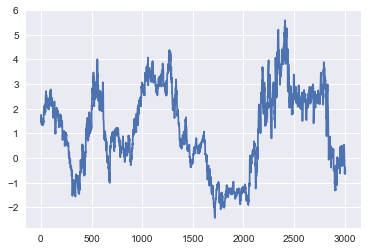

In [242]:
def sharpe_6m(net_pips, years):
    ret_ = [net_pips[i] - net_pips[i-1] for i in range(1, len(net_pips))]
    
    # trades/years/2 = trades per 6-month span
    n_6m = math.ceil(len(ret_)/years/2)
    
    trailing_mean = [np.mean(ret_[i-n_6m:i]) for i in range(n_6m, len(ret_))]
    trailing_std = [np.std(trailing_mean[i-n_6m:i]) for i in range(n_6m, len(trailing_mean))]
    
    # Compute 6 month trailing Sharpe
    sharpe_6m = [trailing_mean[i]/trailing_std[i] for i in range(len(trailing_std))]
    sharpe_avg = sum(sharpe_6m)/len(sharpe_6m)
    
    return sharpe_6m, sharpe_avg

plt.plot(sharpe_6m(cumulative_net, 5)[0])
print(sharpe_6m(cumulative_net, 5)[1])

In [ ]:
print(index[entryvals[:]])

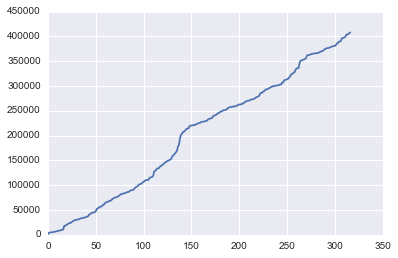

In [19]:
#plt.plot(rates)
#plt.plot(entryvals)
plt.plot(exitvals)
plt.show()